# Evolution of Einstein's equations

# Initial data , setting length of the domain and discretization


In [128]:
# Parameters
m = 1
A = 0.001#0.1449

0.001

In [129]:
res=m;
N=2.0^m*75/3*2#2.0^m*1000.0;#2.0^m*500.0;#N=2.0^m*500.0#2.0^m*100.0;
Xf=1.0;

dx=Xf/N;
dt=round(dx,digits=10);
Nt=100.0*2^m*10#100.0*2^m*10
Tf=Nt*dt; #final time

println("the final time is ", Tf)

the final time is 20.0


In [130]:
print(N)

100.0

In [131]:
println("dx =", dx)
println("dt =", dt)
println("dx/dt =", dx/dt)
println("epsilon <= dx/dt * (1/2)^(2*2-1) = ", dx/dt*(1/2)^(2*2-1))

println("epsilon = dx/dt * (1/2)^(2*2) = ", dx/dt*(1/2)^(2*2))

println("epsilon = dx/dt * (1/2)^(2*3) = ", dx/dt*(1/2)^(2*3))

println("epsilon = dx/dt * (1/2)^(2) = ", dx/dt*(1/2)^(2))

dx =0.01
dt =0.01
dx/dt =1.0
epsilon <= dx/dt * (1/2)^(2*2-1) = 0.125
epsilon = dx/dt * (1/2)^(2*2) = 0.0625
epsilon = dx/dt * (1/2)^(2*3) = 0.015625
epsilon = dx/dt * (1/2)^(2) = 0.25


In [132]:
# Setting RESOLUTION

global dir = "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res$res"
#global dir = "/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res"

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res1"

In [133]:
epsilon=0.1##0.01#0.05; #05; #02;#0.05; #0.05; #0.05;#0.05;#0.05; #dissipation strength (-1 for backwards integration)

0.1

# Grid

In [134]:
ori=0.0;
initX1 = nothing
initX1=range(ori, stop=Xf, step=dx);

In [135]:
initX = range(round(ori-3.0*dx,digits=10), stop=Xf+3.0*dx, step=dx)

L=length(initX);
println("step size is  ", dx)

#T=range(dt,stop=Tf,step=dt)
T=range(0,stop=Tf,step=dt)
println("the time step is ", dt)

step size is  0.01
the time step is 0.01


In [136]:
include("./ScalarField.jl");

In [137]:
using Interpolations

# Initial data of m β Ψ and Ψ,x

In [138]:
using PyCall   


scipy = pyimport("scipy")
scipyinterpolate = pyimport("scipy.interpolate")


####

initm=zeros(L);
initbeta=zeros(L);
initpsi=zeros(L);
initderpsi=zeros(L);

state_array=[initm initbeta initpsi initderpsi initX];

#PSI
r0=0.7#0.3
sigma=0.3
initpsi[4:L-3] = init_gaussian(initX1,r0,sigma,A)

state_array[:,3] = initpsi
state_array = ghost(state_array)

#PSI,X FROM PSI
"""for i in 4:L-3
    initderpsi[i]=Der(state_array[:,:],i,3,initX)
end

state_array[:,4] = initderpsi
state_array = ghost(state_array)"""

#new
initderpsi[4:L-3] = init_gaussian_der(initX1,r0,sigma,A)
state_array[:,4] = initderpsi
state_array=ghost(state_array)

####

spl_psi = scipyinterpolate.splrep(initX[4:L-3], state_array[4:L-3,3],k=4)
psi_func(x) = scipyinterpolate.splev(x, spl_psi)

spl_derpsi = scipyinterpolate.splrep(initX[4:L-3], initderpsi[4:L-3],k=4)
derpsi_func(x) = scipyinterpolate.splev(x, spl_derpsi)

funcs = [psi_func derpsi_func]

1×2 Matrix{Function}:
 psi_func  derpsi_func

In [139]:
#BETA
beta0=0
initbeta[4:L-3]=rk4wrapper(SFconstraint_beta,beta0,initX1,0,funcs)
state_array[:,2]=initbeta;
state_array=ghost(state_array);


#M
m0=0
initm[4:L-3]=rk4wrapper(SFconstraint_m,m0,initX1,0,funcs)
state_array[:,1]=initm;
state_array = ghost(state_array);

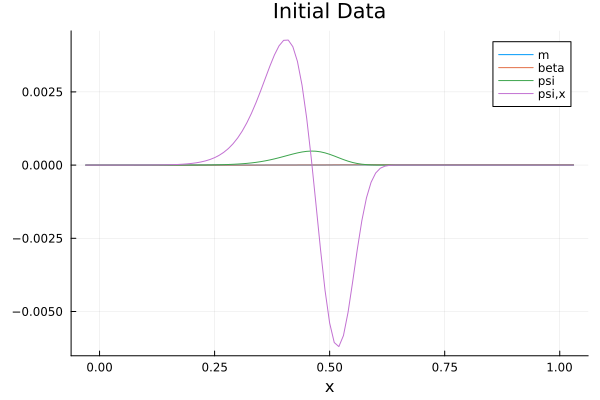

In [140]:
using Plots #showing initial data and the initial status of the horizon finder
plot(initX, state_array[:,1:4], xaxis="x",title="Initial Data", labels=["m" "beta" "psi" "psi,x"])#, xlim=[-0.001, 0.001])"""

# Defining the initial state array for the evolution m β Ψ and Ψ,x

In [141]:
using CSV, Tables
#CSV.write(dir*"/time_step0.csv", Tables.table(transpose(Matrix(state_array))), writeheader=false)
CSV.write(dir*"/time_step0.csv", Tables.table(state_array), writeheader=false)

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res1/time_step0.csv"

In [142]:
timestep=0
criticality=0.0
explode=0.0
critical_stop=0
evol_stats = [criticality A sigma r0 timestep explode]
monitor_ratio = zeros(L)
CSV.write("/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/parameters.csv", Tables.table(evol_stats), writeheader=true, header=["criticality", "A", "sigma", "r0", "timestep", "explode"])

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/parameters.csv"

 ## Time evolution

fixed grid

In [143]:
using Interpolations
using ProgressMeter
@showprogress for t in 1:200#length(T)
    
    if isnan(state_array[L-3,4])
        print("boom at timestep=", t)
        explode = true
        timestep = t
        break
    end
    
    #X = update_grid(state_array[:,:],T,t)
    
    X=initX#initX #state_array[:,5]
    X1=X[4:L-3]

    #update ghost points
    state_array=boundarySF(state_array,X)
   
    #evolve psi,x
    global state_array[:,:] = rungekutta4molstep(SF_RHS,state_array[:,:],T,t,0,X) #evolve psi,x
    #global state_array=ghost(state_array)

    #global aux=SF_RHS(state_array[:,:], 0,0,X)
    
    #calculate psi from psi,x
    global spl_derpsi = scipyinterpolate.splrep(initX[4:L-3], state_array[4:L-3,4],k=4)
    psi0=0
    SFconstraint_psi(psi0,x) = scipyinterpolate.splev(x, spl_derpsi)

    global state_array[4:L-3,3] = rungekutta4(SFconstraint_psi,psi0,initX1)
    #global state_array=ghost(state_array);

    global spl_psi = scipyinterpolate.splrep(initX[4:L-3], state_array[4:L-3,3],k=4)
    global psi_func(x) = scipyinterpolate.splev(x, spl_psi)
    global derpsi_func(x) = scipyinterpolate.splev(x, spl_derpsi)

    global funcs = [psi_func derpsi_func]
    
    #evolve beta
    global state_array[4:L-3,2]=rk4wrapper(SFconstraint_beta,beta0,X1,T[t+1],funcs)
    #global state_array=ghost(state_array)
    
    #evolve m
    global state_array[4:L-3,1]=rk4wrapper(SFconstraint_m,m0,X1,T[t+1],funcs)
    #global state_array=ghost(state_array)
    
    #CSV.write(dir*"/time_step$k.csv", Tables.table(transpose(Matrix(state_array))), writeheader=false)
    CSV.write(dir*"/time_step$t.csv", Tables.table(state_array), writeheader=false)
    
    
    #threshold for apparent black hole formation
    global monitor_ratio = zeros(L)
    for i in 1:L
        global monitor_ratio[i] = 2*state_array[i,1]/initX[i]*(1-initX[i])
        if monitor_ratio[i]>0.6
            global criticality = true
            println("Supercritical evolution!")
            println("i = ", i, " t = ", t, " monitor ratio = ", monitor_ratio[i])
            critical_stop += 1
            timestep = t
        end
    end
    
    if critical_stop >=15
        print("Found apparent horizon formation")
        timestep = t
        break
    end
    timestep = t
end


global evol_stats = [criticality A sigma r0 timestep explode]

CSV.write("/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/parameters.csv", Tables.table(evol_stats), writeheader=true,header=["criticality", "A", "sigma", "r0", "timestep", "explode"]);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:34


In [144]:
dir

"/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/DATA/res1"

## Movie of the evolution

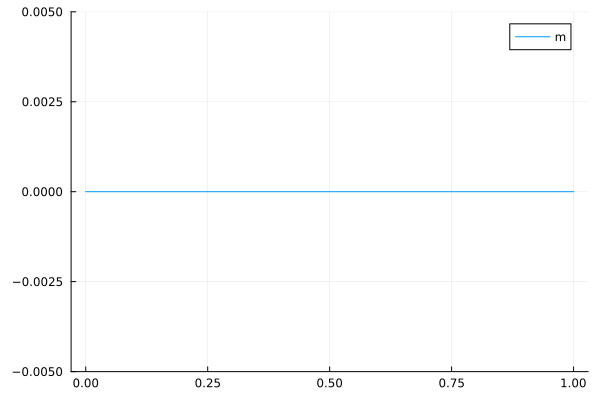

[ Info: Saved animation to /home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/anim_res1.gif


Plots.AnimatedGif("/home/rita13santos/Desktop/MSc Thesis/Git/ScalarField/anim_res1.gif")
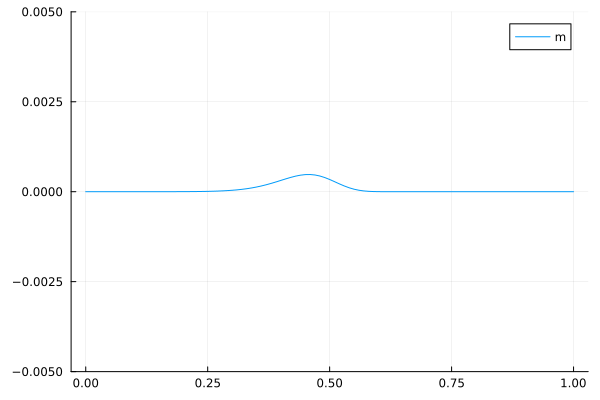

In [146]:
using Plots, CSV, DataFrames
import GR
anim = @animate for n in 1:200#length(T)-1
    time_step=T[n+1]-T[n];
    IJulia.clear_output(true)
    functions3=DataFrame(CSV.File(dir*"/time_step$n.csv",header=false, delim=","))
    plot()
        plot1=functions3.Column1[4:L-3];
        plot2=functions3.Column2[4:L-3];
        plot3=functions3.Column3[4:L-3];
        plot4=functions3.Column4[4:L-3];
    d=round(T[n],digits=1)
    plot!(initX[4:L-3], [plot3], labels=["m" "beta" "psi" "psi,x"],ylim=[-0.005, 0.005]) |> display 
    
    end

gif(anim, "anim_res$res.gif", fps = 5)